# Урок 6. Градиентный бустинг

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)

In [4]:
X.shape

(442, 10)

In [5]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [6]:
X_train

array([[-0.01641217, -0.04464164, -0.05255187, ..., -0.03949338,
        -0.06832974, -0.03007245],
       [ 0.06350368,  0.05068012, -0.02560657, ..., -0.00259226,
         0.03839325,  0.01963284],
       [ 0.04534098, -0.04464164,  0.03906215, ..., -0.01255556,
         0.06432823,  0.0569118 ],
       ...,
       [-0.07816532, -0.04464164, -0.0730303 , ..., -0.03949338,
        -0.01811827, -0.08391984],
       [-0.00914709, -0.04464164, -0.06225218, ..., -0.03949338,
        -0.03581673, -0.04664087],
       [-0.05273755, -0.04464164,  0.07139652, ..., -0.02141183,
        -0.04687948,  0.00306441]])

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [7]:
def gb_predict(X, trees_list, coef_list, eta):
    return np.array([sum([eta*coef*alg.predict([x])[0] for alg, coef in zip(trees_list,coef_list)]) for x in X])


В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функицию.

In [8]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [9]:
def deriv(y, z):
    return 2*(y - z)

Реализуем функцию обучения градиентного бустинга.

In [10]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            pred = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, deriv(y_train, pred))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [11]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

# %%time
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [12]:
coefs

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [14]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [15]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 2870.2850578321027
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тестовой выборке: 10577.32200850624


Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций.

In [16]:
import matplotlib.pyplot as plt

In [17]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

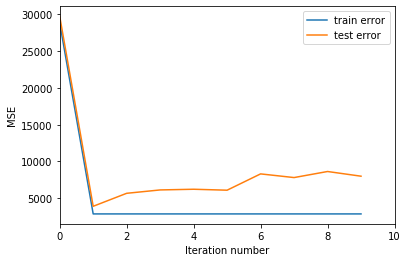

In [18]:
get_error_plot(n_trees, train_errors, test_errors)

Такой результат не является удовлетворительным

Увеличим число деревьев.

In [20]:
n_trees = 30
coefs = [1] * n_trees

# %%time
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [21]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 30 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 2870.285057832105
Ошибка алгоритма из 30 деревьев глубиной 3     с шагом 1 на тестовой выборке: 8302.91230863764


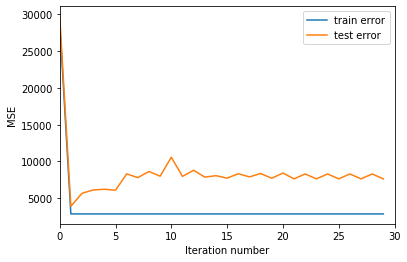

In [22]:
get_error_plot(n_trees, train_errors, test_errors)

Теперь попробуем уменьшить шаг.

In [26]:
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [27]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 30 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 1308.306946379261
Ошибка алгоритма из 30 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 3525.9362181884812


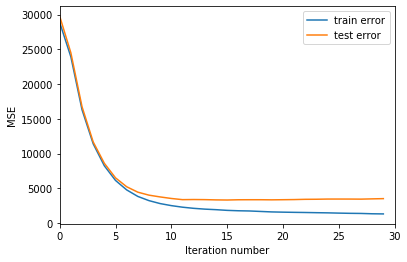

In [28]:
get_error_plot(n_trees, train_errors, test_errors)

Видим, что качество обучения улучшается.

Уменьшим шаг до 0.01.

In [29]:
eta = 0.01

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [30]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 30 деревьев глубиной 3     с шагом 0.01 на тренировочной выборке: 10653.851962101218
Ошибка алгоритма из 30 деревьев глубиной 3     с шагом 0.01 на тестовой выборке: 10939.945924375648


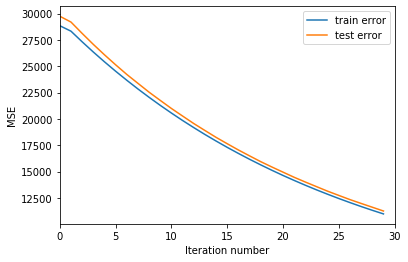

In [31]:
get_error_plot(n_trees, train_errors, test_errors)

При таком размере шага алгоритм сходится, но ему для достижения удовлетворительных показателей требуется большее количество итераций.

Вернемся к шагу 0.1 и попробуем увеличить глубину деревьев

In [32]:
eta = 0.1
max_depth = 5

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [33]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 30 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 280.3318761621302
Ошибка алгоритма из 30 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 3918.067092257136


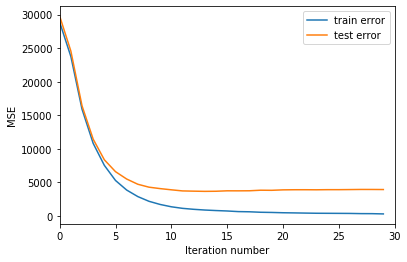

In [35]:
get_error_plot(n_trees, train_errors, test_errors)

### Домашнее задание:  
#### 1. Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Cделать выводы о зависимости ошибки от этих параметров. 

In [54]:
train_errors = []
test_errors = []
eta = 0.1
coefs = [1] * n_trees
max_depth = 3

for n_trees in range(1, 15):
    trees, train_errors_, test_errors_ = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    train_errors.append(mean_squared_error(y_train, train_prediction))
    test_errors.append(mean_squared_error(y_test, test_prediction))

train_errors5 = []
test_errors5 = []
max_depth = 5
for n_trees in range(1, 15):
    trees5, train_errors_5, test_errors_5 = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_prediction5 = gb_predict(X_train, trees5, coefs, eta)
    test_prediction5 = gb_predict(X_test, trees5, coefs, eta)
    train_errors5.append(mean_squared_error(y_train, train_prediction5))
    test_errors5.append(mean_squared_error(y_test, test_prediction5))

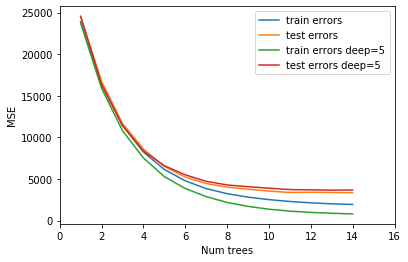

In [55]:
x = list(range(1, 15))

plt.xlim(0, 16)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.plot(x, train_errors5, label='train errors deep=5')
plt.plot(x, test_errors5, label='test errors deep=5')
plt.xlabel('Num trees')
plt.ylabel('MSE')
plt.legend(loc='upper right');

In [63]:
train_errors = []
test_errors = []
eta = 0.1
n_trees = 5
coefs = [1] * n_trees


for max_depth in range(1, 25):
    trees, train_errors_, test_errors_ = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    train_errors.append(mean_squared_error(y_train, train_prediction))
    test_errors.append(mean_squared_error(y_test, test_prediction))

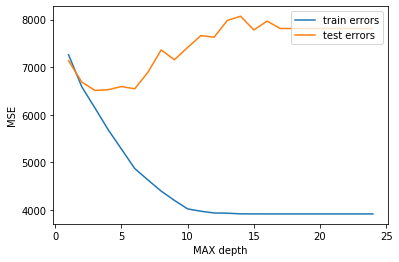

In [64]:
x = list(range(1, 25))


plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('MAX depth')
plt.ylabel('MSE')
plt.legend(loc='upper right');

MSE выходит на ассимптотму и практически не изменяется (при max_depth = 3) при n_trees =7 и  существенно лучшие значения MSE достигаются при max_depth = 5, так MSE ниже и выходит на ассимптоту позднее, при n_trees = 14. С увеличением глубины сходимость алгоритма нарушается. 
